Sampling: [alpha_Australia, alpha_Canada, alpha_Chile, alpha_Ireland, alpha_New Zealand, alpha_South Africa, alpha_United Kingdom, alpha_United States, alpha_hat_location, alpha_hat_scale, beta_hat_location, beta_hat_scale, lag_coefs_Australia, lag_coefs_Canada, lag_coefs_Chile, lag_coefs_Ireland, lag_coefs_New Zealand, lag_coefs_South Africa, lag_coefs_United Kingdom, lag_coefs_United States, noise_chol_Australia, noise_chol_Canada, noise_chol_Chile, noise_chol_Ireland, noise_chol_New Zealand, noise_chol_South Africa, noise_chol_United Kingdom, noise_chol_United States, obs_Australia, obs_Canada, obs_Chile, obs_Ireland, obs_New Zealand, obs_South Africa, obs_United Kingdom, obs_United States, omega_global, rho, z_scale_alpha_Australia, z_scale_alpha_Canada, z_scale_alpha_Chile, z_scale_alpha_Ireland, z_scale_alpha_New Zealand, z_scale_alpha_South Africa, z_scale_alpha_United Kingdom, z_scale_alpha_United States, z_scale_beta_Australia, z_scale_beta_Canada, z_scale_beta_Chile, z_scale_

Error in callback <function _draw_all_if_interactive at 0x7f3252362320> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f327e8422c0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

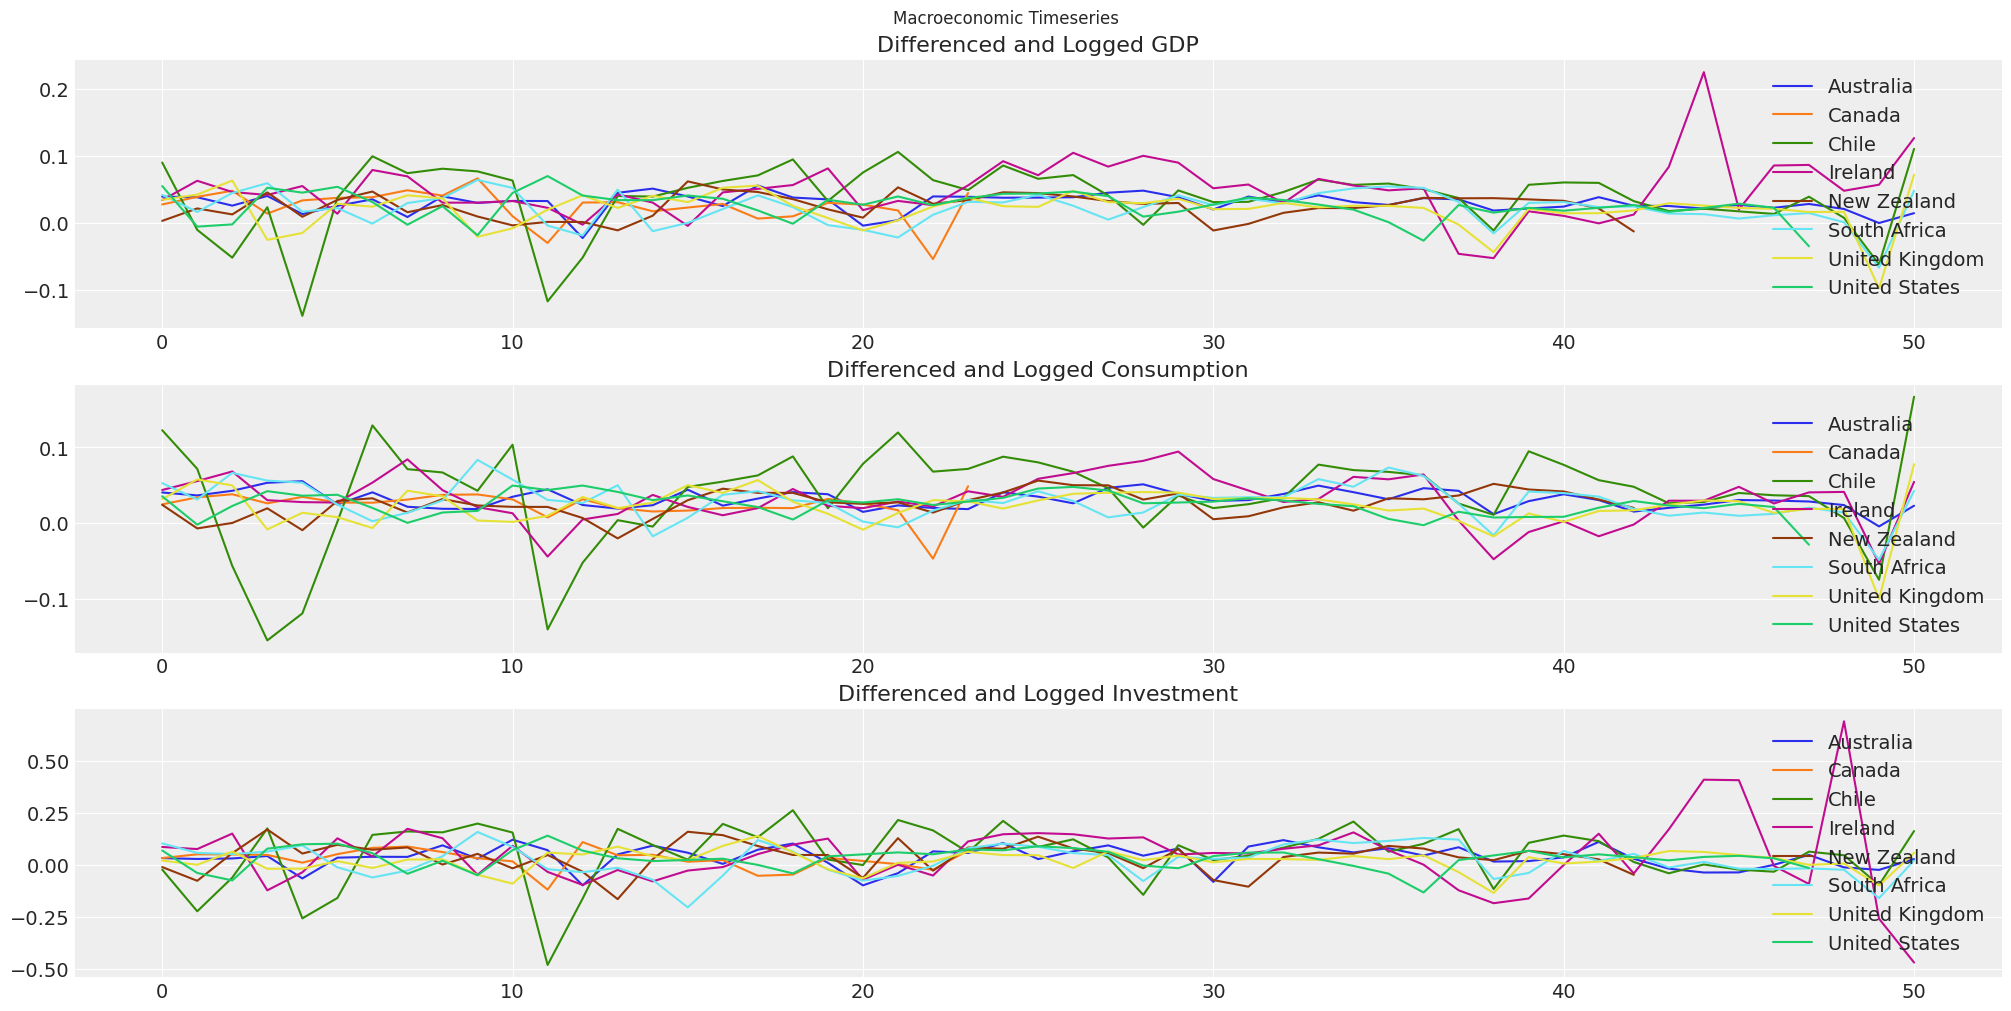

In [4]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
# %config InlineBackend.figure_format = 'retina'

def load_toy_gdp_data():
    try:
        gdp_hierarchical = pd.read_csv(
            os.path.join("..", "data", "gdp_data_hierarchical_clean.csv"), index_col=0
        )
    except FileNotFoundError:
        gdp_hierarchical = pd.read_csv(pm.get_data("gdp_data_hierarchical_clean.csv"))
    return gdp_hierarchical

## May not need
def plot_toy_gdp_data(gdp_hierarchical):
    fig, axs = plt.subplots(3, 1, figsize=(20, 10))
    for country in gdp_hierarchical["country"].unique():
        temp = gdp_hierarchical[gdp_hierarchical["country"] == country].reset_index()
        axs[0].plot(temp["dl_gdp"], label=f"{country}")
        axs[1].plot(temp["dl_cons"], label=f"{country}")
        axs[2].plot(temp["dl_gfcf"], label=f"{country}")
    axs[0].set_title("Differenced and Logged GDP")
    axs[1].set_title("Differenced and Logged Consumption")
    axs[2].set_title("Differenced and Logged Investment")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.suptitle("Macroeconomic Timeseries")

    
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
### Notes: this is just matrix A above.
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta


def make_hierarchical_model(n_lags, n_eqs, df, group_field, prior_checks=True):
    # group_field : Name of column in df that determines country/field
    cols = [col for col in df.columns if col != group_field]
    coords = {"lags": np.arange(n_lags) + 1, "equations": cols, "cross_vars": cols}

    groups = df[group_field].unique()

    with pm.Model(coords=coords) as model:
        ## Hierarchical Priors
        rho = pm.Beta("rho", alpha=2, beta=2)
        alpha_hat_location = pm.Normal("alpha_hat_location", 0, 0.1)
        alpha_hat_scale = pm.InverseGamma("alpha_hat_scale", 3, 0.5)
        beta_hat_location = pm.Normal("beta_hat_location", 0, 0.1)
        beta_hat_scale = pm.InverseGamma("beta_hat_scale", 3, 0.5)
        omega_global, _, _ = pm.LKJCholeskyCov(
            "omega_global", n=n_eqs, eta=1.0, sd_dist=pm.Exponential.dist(1)
        )

        for grp in groups:
            df_grp = df[df[group_field] == grp][cols]
            z_scale_beta = pm.InverseGamma(f"z_scale_beta_{grp}", 3, 0.5)
            z_scale_alpha = pm.InverseGamma(f"z_scale_alpha_{grp}", 3, 0.5)
            lag_coefs = pm.Normal(
                f"lag_coefs_{grp}",
                mu=beta_hat_location,
                sigma=beta_hat_scale * z_scale_beta,
                dims=["equations", "lags", "cross_vars"],
            )
            alpha = pm.Normal(
                f"alpha_{grp}",
                mu=alpha_hat_location,
                sigma=alpha_hat_scale * z_scale_alpha,
                dims=("equations",),
            )

            betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df_grp)
            betaX = pm.Deterministic(f"betaX_{grp}", betaX)
            mean = alpha + betaX

            n = df_grp.shape[1]
            noise_chol, _, _ = pm.LKJCholeskyCov(
                f"noise_chol_{grp}", eta=10, n=n, sd_dist=pm.Exponential.dist(1)
            )
            omega = pm.Deterministic(f"omega_{grp}", rho * omega_global + (1 - rho) * noise_chol)
            obs = pm.MvNormal(f"obs_{grp}", mu=mean, chol=omega, observed=df_grp.values[n_lags:])

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            # idata.extend(sample_blackjax_nuts(2000, random_seed=120))
            idata.extend(pm.sample(2000, random_seed=120))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    return model, idata

def run():
    gdp_hierarchical = load_toy_gdp_data()
    plot_toy_gdp_data(gdp_hierarchical)
    df_final = gdp_hierarchical[["country", "dl_gdp", "dl_cons", "dl_gfcf"]]
    model_full_test, idata_full_test = make_hierarchical_model(
        2,
        3,
        df_final,
        "country",
        prior_checks=False,
    )


run()
